In [1]:
# https://chokkan.github.io/mlnote/classification/02multi.html
# 線形多クラス分類
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# mnist.npz を作成するプログラム
# mnistのデータセットをnumpy形式に変換するもの。npz同一ディレクトリにない場合にのみ回すものなので、一旦コメントアウト。
'''
import gzip
import numpy as np
import sys
import struct
import urllib.request

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )
'''

In [3]:
data = np.load('mnist.npz')

print("Training data (X):", data['train_x'].shape, data['train_x'].dtype)# float32 28行28列の行列→多分輝度を28x28の行列で示してる
print("Training data (Y):", data['train_y'].shape, data['train_y'].dtype)# 8bit 符号なし整数配列(普通にint型の数字入ってた)→正解が入ってる
print("Test data (X):", data['test_x'].shape, data['test_x'].dtype)
print("Test data (Y):", data['test_y'].shape, data['test_y'].dtype)

# 例) 左上から数えて↓に7番目、→に8番目のピクセルの画素数にアクセスする場合 → x[7][8] でアクセスできる(内容物:0.93...)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


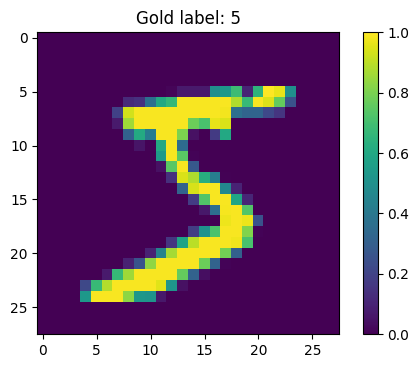

In [8]:
i = 0
x = data['train_x'][i]
y = data['train_y'][i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title('Gold label: {}'.format(y))
im = ax.imshow(x)
fig.colorbar(im)
plt.show()

In [13]:
def images_to_vectors(X):# 複数の行列(画像)をまとめてベクトルに変換する関数
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]        # Append 1: (N x 784) -> (N x 785) 多次元配列の結合(ケツに1. をつける処理)

In [14]:
X_train = images_to_vectors(data['train_x'])
X_test = images_to_vectors(data['test_x'])

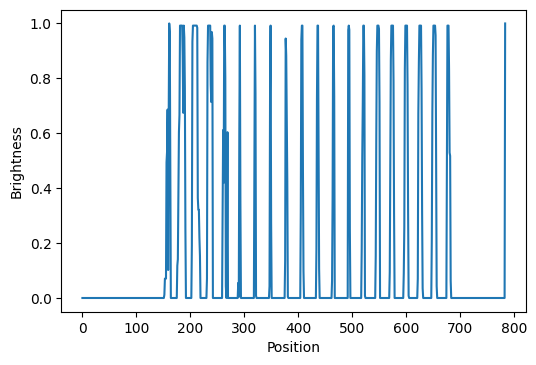

In [15]:
# 学習データの0番目を可視化してみる
x = X_train[i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(x)), x)
ax.set_xlabel('Position')
ax.set_ylabel('Brightness')
plt.show()

In [16]:
x[204]# 28 x 7 + 8 番目の輝度

0.9333333373069763

In [ ]:
# 線形多クラス回帰 > 多クラスロジスティック回帰を選択することにした。

In [20]:
def softmax(a):# オーバーフローしないソフトマックス関数の実装方法
    ea = np.exp(a - np.max(a))
    return ea / ea.sum()

In [18]:
a = np.array([0.1, -0.2, 0.3, -0.4, 0.5])
softmax(a)

array([0.19760595, 0.14639009, 0.24135645, 0.11985407, 0.29479344])

/tmp/ipykernel_5366/3115073462.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


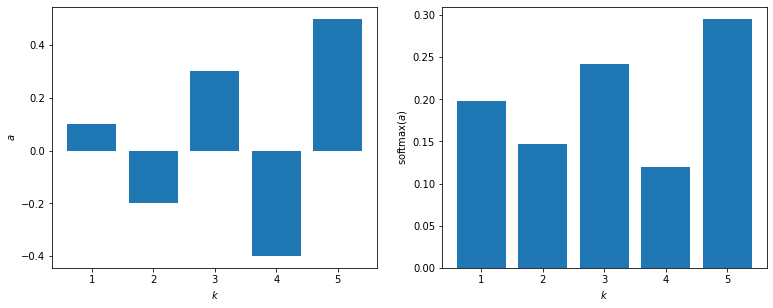

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax1.bar(range(1, 6), a)
ax1.set_xlabel('$k$')
ax1.set_ylabel('$a$')
ax2.bar(range(1, 6), softmax(a))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'${\rm softmax}(a)$')
fig.show()

In [21]:
# 実装

import numpy as np
from sklearn.linear_model import SGDClassifier

def image_to_vector(X):
    return np.reshape(X, (len(X), -1))  # Flatten: (N x 28 x 28) -> (N x 784)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 784) (no bias term)
Ytrain = data['train_y']                        # (60000) (not one-hot encoding)
Xtest = image_to_vector(data['test_x'])         # (10000 x 784) (no bias term)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

model = SGDClassifier(loss='log')
model.fit(Xtrain, Ytrain)

SGDClassifier(loss='log')

In [22]:
# 予測
model.predict(Xtest[0:1])

array([7], dtype=uint8)

In [23]:
# 評価データ上での正解率を計測
model.score(Xtest, Ytest)

0.9173

In [24]:
# 混同行列を得る → 2 値分類問題で出力されたクラス分類の結果をまとめたマトリックス(行列≒表)
from sklearn.metrics import confusion_matrix
Ytest_pred = model.predict(Xtest)
confusion_matrix(Ytest, Ytest_pred)

array([[ 955,    0,    2,    2,    0,    9,    5,    2,    2,    3],
       [   0, 1101,    4,    2,    1,    1,    4,    2,   20,    0],
       [   7,    4,  938,    7,   10,    5,    9,    9,   39,    4],
       [   4,    2,   30,  880,    2,   43,    3,   12,   22,   12],
       [   1,    1,    8,    0,  912,    1,    4,    1,   10,   44],
       [   8,    2,    3,   12,   10,  806,   12,    4,   28,    7],
       [  12,    3,    8,    2,    8,   26,  895,    1,    3,    0],
       [   2,    9,   25,    5,   10,    2,    1,  931,    2,   41],
       [   7,    5,    9,   11,   13,   42,    9,   13,  852,   13],
       [   7,    7,    2,    8,   34,   15,    0,   23,   10,  903]])

In [25]:
# 各クラスごとの適合率、再現率、F1スコアを算出

from sklearn.metrics import precision_score, recall_score, f1_score
Ytest_pred = model.predict(Xtest)

In [26]:
# 適合率(precision)を算出 → 本物のデータ / 本物だと予測したデータ → 誤検知を少なくしたい場合これを重視

precision_score(Ytest, Ytest_pred, average=None)

array([0.95214357, 0.97089947, 0.91156463, 0.94725511, 0.912     ,
       0.84842105, 0.95010616, 0.93286573, 0.86234818, 0.87925998])

In [27]:
# 再現率(recall)を算出 → 本物のうち正解したデータ / 本物のデータ → 本物の見逃しを少なくしたいときにはこれを重視

recall_score(Ytest, Ytest_pred, average=None)

array([0.9744898 , 0.97004405, 0.90891473, 0.87128713, 0.9287169 ,
       0.90358744, 0.934238  , 0.90564202, 0.87474333, 0.89494549])

In [28]:
# F1スコアを算出 → 適合率と再現率を当価値として評価するもの。この値が高いほどよいモデルとして評価される。 → (recall x precision) / (recall + precision)

f1_score(Ytest, Ytest_pred, average=None)

array([0.96318709, 0.97047157, 0.91023775, 0.90768437, 0.92028254,
       0.87513572, 0.94210526, 0.91905232, 0.86850153, 0.8870334 ])

In [ ]:
# マクロ(全体)の平均適合率、再現率、F1スコアを算出

In [29]:
# 適合率(マクロ)
precision_score(Ytest, Ytest_pred, average='macro')

0.9166863878937178

In [30]:
# 再現率(マクロ)

recall_score(Ytest, Ytest_pred, average='macro')

0.9166608890644401

In [31]:
# F1スコア(マクロ)

f1_score(Ytest, Ytest_pred, average='macro')

0.9163691561502045

### マイクロ平均適合率、再現率、F1スコアを算出

In [32]:
# 平均適合率

precision_score(Ytest, Ytest_pred, average='micro')

0.9173

In [35]:
# 再現率

recall_score(Ytest, Ytest_pred, average='micro')

0.9173

In [36]:
# F1スコア

f1_score(Ytest, Ytest_pred, average='micro')

0.9173000000000001

/tmp/ipykernel_5366/1257244357.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


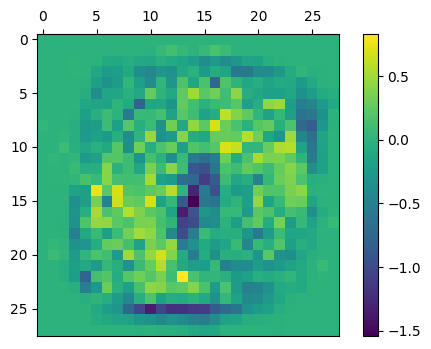

In [37]:
# K x d の重み行列を2次元に変換して可視化

w = model.coef_[0].reshape(28, 28)

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.xaxis.tick_top()
im = ax.imshow(w)
fig.colorbar(im, ax=ax)
fig.show()